In [1]:
import os, zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
from google.colab import drive

# 掛載 Google Drive
drive.mount('/content/drive', force_remount=True)

# 解壓縮資料
zip_path = '/content/drive/MyDrive/face_glasses.zip'
extract_path = '/content'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

Mounted at /content/drive


In [2]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_path = '/content/face_glasses/train'
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True
)

class_names = train_dataset.class_names
positive_idx = class_names.index("positive")
negative_idx = class_names.index("negative")

train_all = list(train_dataset.unbatch())
positive_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == positive_idx]
negative_train = [(x.numpy(), y.numpy()) for x, y in train_all if y.numpy() == negative_idx]

# 建立 VAE 訓練資料集（只用無眼鏡）
vae_train_dataset = tf.data.Dataset.from_tensor_slices([x for x, _ in negative_train])
vae_train_dataset = vae_train_dataset.map(lambda x: x / 255.0)
vae_train_dataset = vae_train_dataset.batch(BATCH_SIZE, drop_remainder=True)

# 驗證集：positive 資料夾
val_path = '/content/face_glasses/validation/positive'
vae_val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels=None,
    label_mode=None,
    batch_size=1,
    image_size=IMG_SIZE,
    shuffle=False
).map(lambda x: x / 255.0)

print(f"✅ 訓練資料量（無眼鏡）: {len(negative_train)}")
print(f"✅ 預覽樣本（有眼鏡）: {len(positive_train)}")

Found 141 files belonging to 2 classes.
Found 20 files.
✅ 訓練資料量（無眼鏡）: 81
✅ 預覽樣本（有眼鏡）: 60


In [3]:
# 定義 Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 128

# Encoder
encoder_inputs = keras.Input(shape=(160, 160, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(20 * 20 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((20, 20, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [4]:
def build_discriminator(input_shape=(160, 160, 3)):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(128, 4, strides=2, padding='same', activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs, x, name="discriminator")

# 這樣就會有一個 Discriminator 了
discriminator = build_discriminator()


In [5]:
class VAEGAN(keras.Model):
    def __init__(self, encoder, decoder, discriminator, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.discriminator = discriminator

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.gan_loss_tracker = keras.metrics.Mean(name="gan_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.gan_loss_tracker
        ]

    def compile(self, vae_optimizer, disc_optimizer):
        super().compile()
        self.vae_optimizer = vae_optimizer
        self.disc_optimizer = disc_optimizer
        self.bce_loss = keras.losses.BinaryCrossentropy(from_logits=False)

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape(persistent=True) as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # VAE Loss
            recon_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3)))
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))

            # GAN Loss
            real_output = self.discriminator(data)
            fake_output = self.discriminator(reconstruction)

            disc_loss = self.bce_loss(tf.ones_like(real_output), real_output) + \
                        self.bce_loss(tf.zeros_like(fake_output), fake_output)

            gan_loss = self.bce_loss(tf.ones_like(fake_output), fake_output)

            # Total loss (for VAE branch)
            total_vae_loss = recon_loss + kl_loss + 0.1 * gan_loss  # GAN loss 權重 0.1，可調

        # 更新 VAE (encoder + decoder)
        grads = tape.gradient(total_vae_loss, self.encoder.trainable_weights + self.decoder.trainable_weights)
        self.vae_optimizer.apply_gradients(zip(grads, self.encoder.trainable_weights + self.decoder.trainable_weights))

        # 更新 Discriminator
        disc_grads = tape.gradient(disc_loss, self.discriminator.trainable_weights)
        self.disc_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_weights))

        self.total_loss_tracker.update_state(total_vae_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.gan_loss_tracker.update_state(gan_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "gan_loss": self.gan_loss_tracker.result()
        }


In [6]:
# 建立 VAEGAN
vaegan = VAEGAN(encoder, decoder, discriminator)

# 分別設定兩個 optimizer
vae_optimizer = keras.optimizers.Adam(learning_rate=1e-4)
disc_optimizer = keras.optimizers.Adam(learning_rate=1e-4)

vaegan.compile(
    vae_optimizer=vae_optimizer,
    disc_optimizer=disc_optimizer
)


🚂 開始訓練 50 epochs... 請稍候～
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 140ms/step - gan_loss: 0.7339 - kl_loss: 0.1780 - loss: 4773.8931 - reconstruction_loss: 4773.6421
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - gan_loss: 0.8195 - kl_loss: 0.0408 - loss: 4766.3706 - reconstruction_loss: 4766.2476
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - gan_loss: 0.9651 - kl_loss: 3.9994e-04 - loss: 4759.1323 - reconstruction_loss: 4759.0356
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - gan_loss: 1.1586 - kl_loss: 7.3024e-05 - loss: 4752.0225 - reconstruction_loss: 4751.9062
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - gan_loss: 1.3556 - kl_loss: 7.5873e-05 - loss: 4744.8818 - reconstruction_loss: 4744.7466
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - gan_loss: 1.6116 - kl_loss: 1.4892e-05 - loss: 4737.5444 - reconstruction_loss: 4737.3833
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - gan_loss: 1.9106 - kl_loss: 1.9145e-05 - loss: 4729.6738 - reconstruction_loss

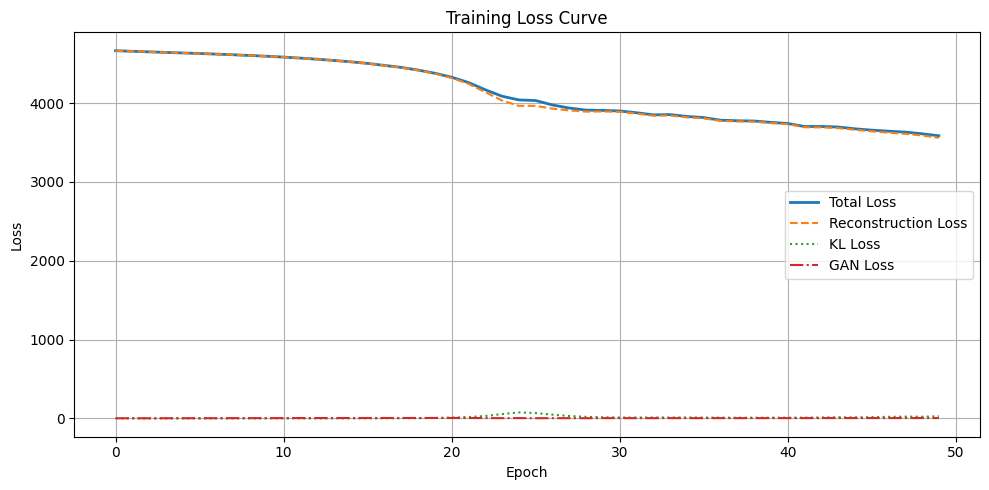

🎯 完成！


In [7]:
import matplotlib.pyplot as plt

def train_and_plot(model, dataset, epochs=50):
    """
    幫你訓練模型並且自動畫出 loss 曲線。

    Args:
        model: VAE 或 VAEGAN 類型的 keras.Model
        dataset: tf.data.Dataset (輸入資料)
        epochs: 訓練幾個 epoch
    """
    if model is None or dataset is None:
        print("❗ 請先確定 model 和 dataset 都有正確建立！")
        return

    print(f"🚂 開始訓練 {epochs} epochs... 請稍候～")
    history = model.fit(dataset, epochs=epochs)

    print(f"✅ 訓練完成，開始畫 loss 曲線")

    plt.figure(figsize=(10, 5))
    if "loss" in history.history:
        plt.plot(history.history["loss"], label="Total Loss", linewidth=2)
    if "reconstruction_loss" in history.history:
        plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss", linestyle="--")
    if "kl_loss" in history.history:
        plt.plot(history.history["kl_loss"], label="KL Loss", linestyle=":")
    if "gan_loss" in history.history:
        plt.plot(history.history["gan_loss"], label="GAN Loss", linestyle="-.")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("🎯 完成！")

    return history



history = train_and_plot(vaegan, vae_train_dataset, epochs=50)

In [8]:
def show_reconstructions(img_dir, encoder, decoder, num_pairs=8, img_size=(160, 160), save_path=None):
    from PIL import Image
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import random

    assert num_pairs % 4 == 0, "num_pairs must be a multiple of 4 for 4-column layout"

    files = os.listdir(img_dir)
    sample_files = random.sample(files, num_pairs)

    cols = 4  # 每列 4 組
    rows = num_pairs // cols  # 幾列組圖

    fig, axs = plt.subplots(rows * 2, cols, figsize=(cols * 2, rows * 5))
    plt.subplots_adjust(hspace=0.4)  # 上下間距加大

    for i, file in enumerate(sample_files):
        img = Image.open(os.path.join(img_dir, file)).resize(img_size)
        img = np.array(img).astype("float32") / 255.0
        img_batch = np.expand_dims(img, axis=0)

        z_mean, z_log_var, z = encoder.predict(img_batch, verbose=0)
        reconstructed = decoder.predict(z, verbose=0)

        row = (i // cols) * 2      # 每組佔兩排
        col = i % cols

        axs[row, col].imshow(img)
        axs[row, col].set_title("With glasses", fontsize=16)
        axs[row, col].axis("off")

        axs[row + 1, col].imshow(np.clip(reconstructed[0], 0, 1))
        axs[row + 1, col].set_title("No glasses", fontsize=16)
        axs[row + 1, col].axis("off")

    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

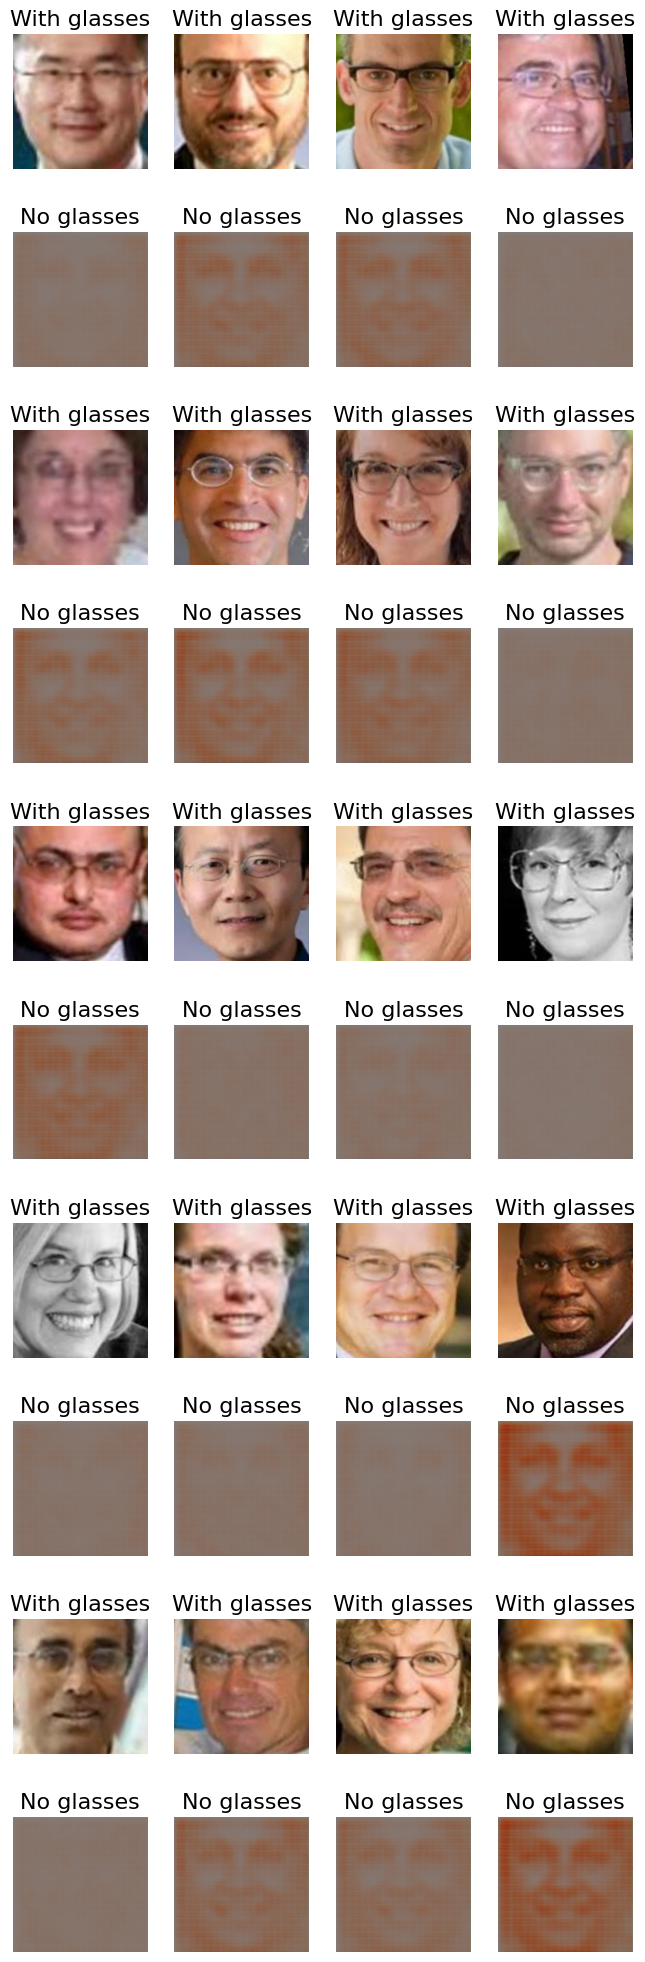

In [9]:
show_reconstructions(
    img_dir="/content/face_glasses/validation/positive",
    encoder=encoder,
    decoder=decoder,
    num_pairs=20
)
